In [84]:
rm(list=ls())

library(DoubleML)
library(ggplot2)
library(mlr3)
library(mlr3learners)
library(repr)
library(data.table)
library(mvtnorm)
suppressMessages(library(parallel))
suppressMessages(library(ggplot2))
suppressMessages(library(doMC))
lgr::get_logger("mlr3")$set_threshold("warn")

numCores <- detectCores()
registerDoMC(cores = numCores)

# LASSO Estimation Function
est_lasso <- function(obj_dml_data) {
    
    #set.seed(70)
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat <- learner$clone()                                  # use LASSO to estimate nuisance g() and m()
    m_hat <- learner$clone()
    
    DML_PLR  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat)   # initialize the DML Partially Linear Model 
    DML_PLR$fit()                                             # Fit the model and extract coefficient estimates
    theta_hat <- DML_PLR$coef
    sd_hat    <- DML_PLR$se
    params    <- cbind(theta_hat,sd_hat)
    return(params)
}

sim_function <- function(data){
    
    DML_data     <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    param_output <- est_lasso(DML_data) 
    return(param_output)
}

In [85]:
unconfounded_DGP <- function(n_obs,dim_x,theta,s) {
    
   # multiplicatives in nuisance functions  
    a_1 = 0.25
    b_1 = 0.25
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # Toeplitz covariance matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1)))
    x       <- rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = cov_mat) 
    
    # nuisance parameter m_0 and propensity function d  
    m_0_x <- x[,1] + a_1 * (exp(x[,3]) /(1 + exp(x[,3])))
    d     <- as.matrix(m_0_x + eps)
    
    # nuisance paraneter g_0 and outcome y
    beta  <- c(rep(0,3), rnorm(s), rep(0,dim_x-s-3))
    g_0_x <- exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3] +  x %*% beta
    y     <- as.matrix(theta*d + g_0_x + ups)

    # Data prep
    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
} 

In [86]:
### Fixed Design Parameters
n_rep  = 50
n_vars = 150
theta  = 1
s      = 0

samples <- seq(30,1000,by=10)
all_theta_estimates <- matrix(NA, nrow=length(samples), ncol=n_rep)

In [87]:
RNGkind("L'Ecuyer-CMRG")
set.seed(70)

for (i in 1:length(samples)) {
    
    boot_fx <- function(iteration) {        
        data        <- unconfounded_DGP(theta=theta,n_obs=samples[i],dim_x=n_vars,s=s)
        theta_estim <- sim_function(data)[1]  
        return(theta_estim) 
    }
    
    parallel_estims         <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    all_theta_estimates[i,] <- do.call(cbind, parallel_estims)

} 

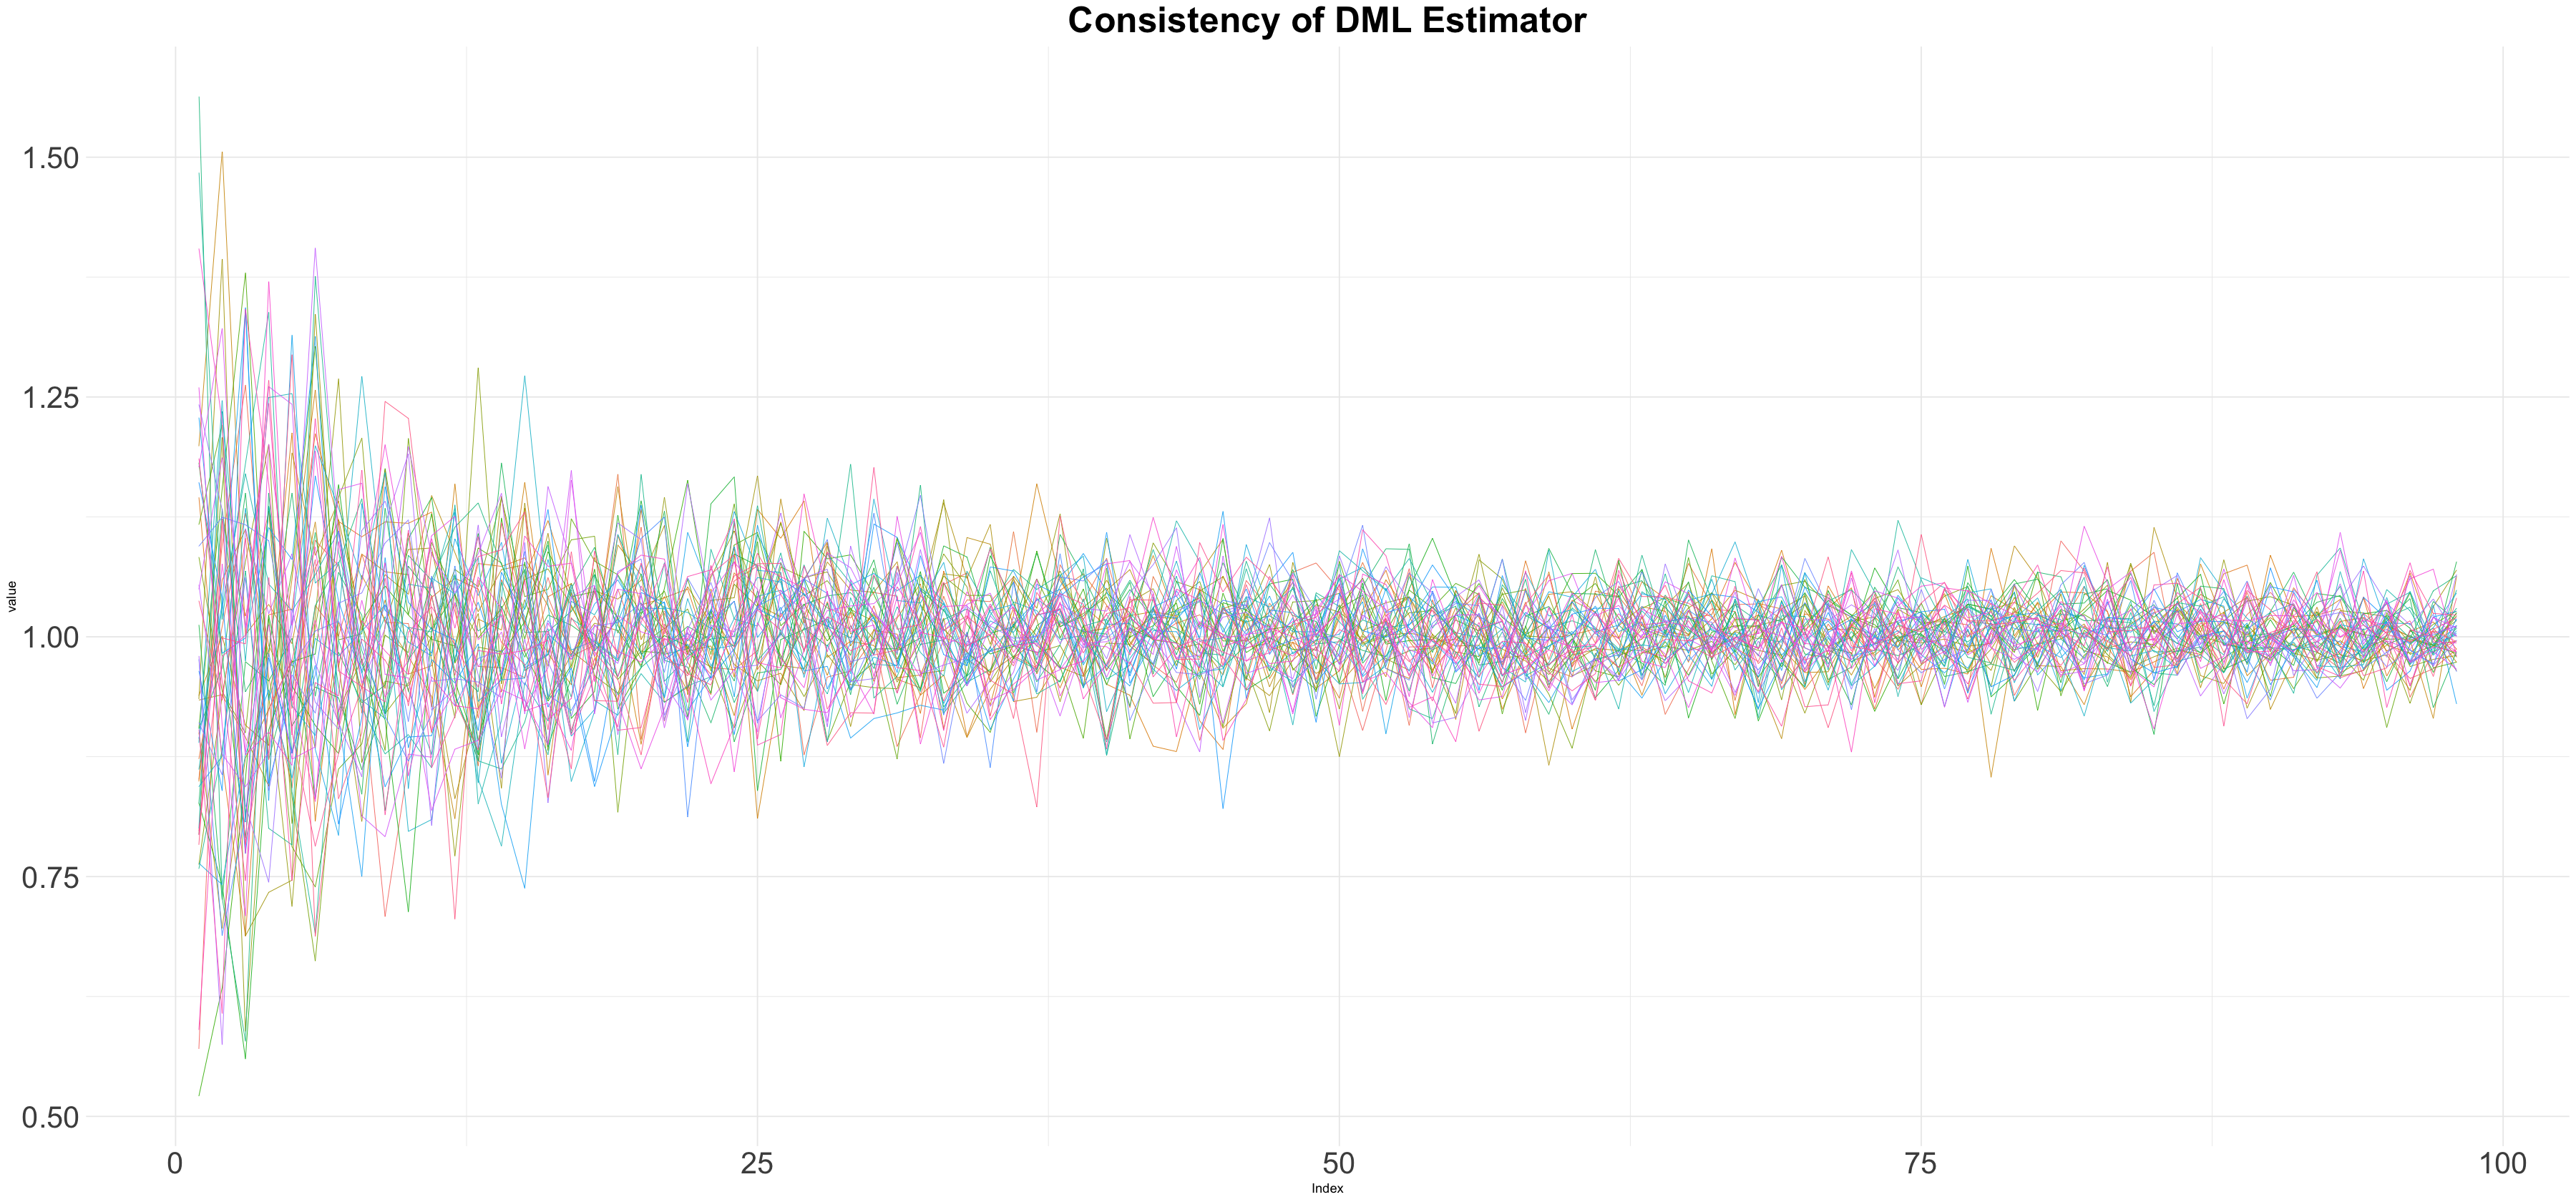

In [124]:
df <- data.frame(Index = 1:length(samples),all_theta_estimates)
df <- melt(df ,  id.vars = 'Index', variable.name = 'series')

ggplot(df, aes(Index,value)) + 
    geom_line(aes(colour = series), size = 0.25) + theme_minimal() + 
        theme(legend.position = "none", plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=25)) +
        ggtitle(paste0("Consistency of DML Estimator")) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)